# **Tugas Individu: Implementasi Arsitektur Transformer dari Nol dengan NumPy**

Oleh:

> Nama: Muhammad Zidane Septian Irsyadi  
NIM: 22/504678/TK/55212

# Komponen yang Wajib Dibuat

> 1. Token Embedding
2. Positional Encoding (sinusoidal atau learned, pilih salah satu)
3. Scaled Dot-Product Attention dengan softmax
4. Multi-Head Attention (Q, K, V, concat, dan proyeksi akhir)
5. Feed-Forward Network (FFN) dua lapisan dengan aktivasi non-linear
6. Residual Connection + Layer Normalization (pre-norm)
7. Causal Masking untuk mencegah akses informasi dari token masa depan
8. Output Layer: proyeksi ke ukuran vocab dan distribusi softmax





## Import NumPy and define some hyperparameters.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Hyperparameters
vocab_size = 1000
d_model = 512
n_heads = 8
n_layers = 6
d_ff = 2048
seq_len = 100
dropout_rate = 0.1

## Token Embedding

In [22]:
class TokenEmbedding:
    def __init__(self, vocab_size, d_model):
        self.embedding = np.random.randn(vocab_size, d_model)

    def forward(self, x):
        """
        x: Input token IDs, shape (batch_size, seq_len)
        Returns embedding vectors, shape (batch_size, seq_len, d_model)
        """
        return self.embedding[x]

## Positional Encoding (Sinusoidal)

In [23]:
def positional_encoding(seq_len, d_model):
    """Menghasilkan matriks positional encoding sinusoidal."""
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]

    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    angle_rads = pos * angle_rates

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    return angle_rads[np.newaxis, :, :]

## Scaled Dot-Product Attention

In [24]:
def softmax(x):
    """Fungsi aktivasi softmax"""
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def scaled_dot_product_attention(q, k, v, mask=None):
    """Menghitung Scaled Dot-Product Attention."""
    matmul_qk = np.matmul(q, k.transpose(0, 1, 3, 2))

    d_k = q.shape[-1]
    scaled_attention_logits = matmul_qk / np.sqrt(d_k)

    if mask is not None:
        scaled_attention_logits += mask

    attention_weights = softmax(scaled_attention_logits)
    output = np.matmul(attention_weights, v)

    return output, attention_weights

## Multi-Head Attention

In [25]:
class MultiHeadAttention:
    def __init__(self, d_model, n_heads):
        self.n_heads = n_heads
        self.d_model = d_model
        assert d_model % n_heads == 0
        self.d_k = d_model // n_heads

        self.wq = np.random.randn(d_model, d_model)
        self.wk = np.random.randn(d_model, d_model)
        self.wv = np.random.randn(d_model, d_model)
        self.dense = np.random.randn(d_model, d_model)

    def split_heads(self, x, batch_size):
        x = x.reshape(batch_size, -1, self.n_heads, self.d_k)
        return x.transpose(0, 2, 1, 3)

    def forward(self, q, k, v, mask):
        batch_size = q.shape[0]

        q = np.matmul(q, self.wq)
        k = np.matmul(k, self.wk)
        v = np.matmul(v, self.wv)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = scaled_attention.transpose(0, 2, 1, 3)
        concat_attention = scaled_attention.reshape(batch_size, -1, self.d_model)

        output = np.matmul(concat_attention, self.dense)
        return output, attention_weights # Mengembalikan attention_weights

## Feed-Forward Network (FFN)

In [26]:
def relu(x):
    return np.maximum(0, x)

class FeedForwardNetwork:
    def __init__(self, d_model, d_ff):
        self.w1 = np.random.randn(d_model, d_ff)
        self.b1 = np.zeros(d_ff)
        self.w2 = np.random.randn(d_ff, d_model)
        self.b2 = np.zeros(d_model)

    def forward(self, x):
        x = relu(np.matmul(x, self.w1) + self.b1)
        x = np.matmul(x, self.w2) + self.b2
        return x

## Residual Connection + Layer Normalization (Pre-Norm)

In [27]:
class LayerNormalization:
    def __init__(self, d_model, epsilon=1e-5):
        self.gamma = np.ones(d_model)  # scale
        self.beta = np.zeros(d_model)   # shift
        self.epsilon = epsilon

    def forward(self, x):
        mean = np.mean(x, axis=-1, keepdims=True)
        std = np.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.epsilon) + self.beta

## Causal Masking

In [28]:
def create_causal_mask(size):
    """Membuat causal mask untuk mencegah perhatian ke token masa depan."""
    mask = np.triu(np.ones((size, size)), k=1) * -1e9
    return mask

In [29]:
class DecoderBlock:
    def __init__(self, d_model, n_heads, d_ff):
        self.mha = MultiHeadAttention(d_model, n_heads)
        self.ffn = FeedForwardNetwork(d_model, d_ff)
        self.layernorm1 = LayerNormalization(d_model)
        self.layernorm2 = LayerNormalization(d_model)

    def forward(self, x, mask):
        norm_x = self.layernorm1.forward(x)
        attn_output, attn_weights = self.mha.forward(norm_x, norm_x, norm_x, mask)
        x = x + attn_output

        norm_x = self.layernorm2.forward(x)
        ffn_output = self.ffn.forward(norm_x)
        x = x + ffn_output

        return x, attn_weights # Mengembalikan attention_weights dari MHA

## Output Layer

In [30]:
class OutputLayer:
    def __init__(self, d_model, vocab_size):
        self.dense = np.random.randn(d_model, vocab_size)

    def forward(self, x):
        return np.matmul(x, self.dense)

In [31]:
class Transformer:
    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, seq_len):
        self.embedding = TokenEmbedding(vocab_size, d_model)
        self.pos_encoding = positional_encoding(seq_len, d_model)
        self.decoder_blocks = [DecoderBlock(d_model, n_heads, d_ff) for _ in range(n_layers)]
        self.output_layer = OutputLayer(d_model, vocab_size)
        self.seq_len = seq_len

    def forward(self, x):
        mask = create_causal_mask(x.shape[1])

        x = self.embedding.forward(x)
        x += self.pos_encoding[:, :x.shape[1], :]

        attention_weights = None
        for i, block in enumerate(self.decoder_blocks):
            x, weights = block.forward(x, mask)
            # Simpan bobot dari layer terakhir untuk visualisasi
            if i == n_layers - 1:
                attention_weights = weights

        logits = self.output_layer.forward(x)
        return logits, attention_weights # Kembalikan logits dan bobot attention terakhir

## Visualisasi Distribution Attention

In [32]:
def visualize_attention(attention_weights, input_tokens_str, head=0, sample=0):
    """Memvisualisasikan matriks attention untuk satu head dan satu sampel."""
    if attention_weights is None:
        print("Attention weights tidak tersedia.")
        return

    attn_matrix = attention_weights[sample, head, :, :]

    plt.figure(figsize=(10, 8))
    sns.heatmap(attn_matrix,
                xticklabels=input_tokens_str,
                yticklabels=input_tokens_str,
                annot=False,
                cmap='viridis')

    plt.xlabel('Key (Token yang Dilihat)')
    plt.ylabel('Query (Token yang Melihat)')
    plt.title(f'Attention Heatmap - Layer Terakhir, Head {head}')
    plt.show()


## Pengujian

--- Verifikasi Bentuk Tensor ---
Bentuk Input Tokens: (1, 15)
Bentuk Logits Output: (1, 15, 1000)
Bentuk Attention Weights: (1, 8, 15, 15)

Ekspektasi Logits: (batch_size, seq_len, vocab_size)
Ekspektasi Attention Weights: (batch_size, n_heads, seq_len, seq_len)

--- Verifikasi Softmax (Probabilitas Token Berikutnya) ---
Bentuk Probabilitas: (1, 1000)
Jumlah probabilitas untuk sampel pertama: 1.0

--- Menampilkan Visualisasi Attention ---


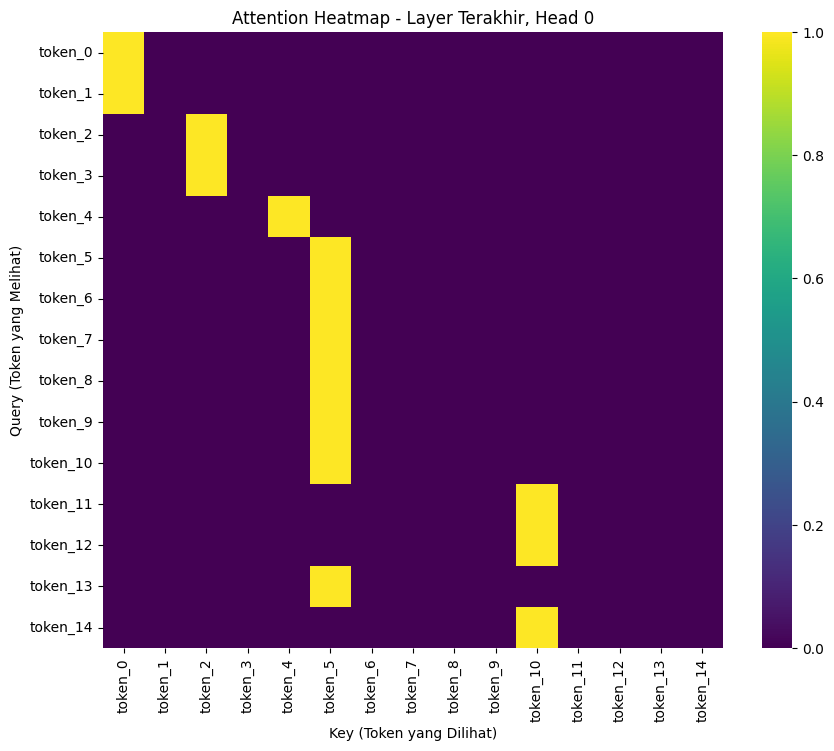

In [33]:
if __name__ == "__main__":
    # Parameter untuk pengujian
    batch_size = 1
    input_seq_len = 15
    input_tokens = np.random.randint(0, vocab_size, size=(batch_size, input_seq_len))

    # Inisialisasi model
    model = Transformer(
        vocab_size=vocab_size,
        d_model=d_model,
        n_layers=n_layers,
        n_heads=n_heads,
        d_ff=d_ff,
        seq_len=seq_len
    )

    # Jalankan forward pass
    logits, attention_weights_final_layer = model.forward(input_tokens)

    # --- Verifikasi Output ---
    print("--- Verifikasi Bentuk Tensor ---")
    print(f"Bentuk Input Tokens: {input_tokens.shape}")
    print(f"Bentuk Logits Output: {logits.shape}")
    print(f"Bentuk Attention Weights: {attention_weights_final_layer.shape}")
    print("\nEkspektasi Logits: (batch_size, seq_len, vocab_size)")
    print("Ekspektasi Attention Weights: (batch_size, n_heads, seq_len, seq_len)\n")

    # --- Verifikasi Softmax ---
    last_token_logits = logits[:, -1, :]
    probs = softmax(last_token_logits)
    print("--- Verifikasi Softmax (Probabilitas Token Berikutnya) ---")
    print(f"Bentuk Probabilitas: {probs.shape}")
    print(f"Jumlah probabilitas untuk sampel pertama: {np.sum(probs[0])}\n") # Harus mendekati 1.0

    # --- Demonstrasi Visualisasi Attention ---
    print("--- Menampilkan Visualisasi Attention ---")
    # Buat label dummy untuk plot
    dummy_labels = [f"token_{i}" for i in range(input_seq_len)]

    # Visualisasikan attention dari head ke-0 pada sampel ke-0 dari batch
    visualize_attention(attention_weights_final_layer, dummy_labels, head=0, sample=0)
